In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize

from sklearn import metrics

Using TensorFlow backend.


In [0]:
from IPython.display import clear_output
# Import necessary library
import pandas as pd
import numpy as np
import nltk
import os
import nltk.corpus
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

path = "/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/InsideAirbnb/data/"
calendar = pd.read_csv(path+"calendar.csv")
listings = pd.read_csv(path+"listings.csv")
reviews = pd.read_csv(path+"reviews.csv")
clear_output()

In [0]:
col_list = list(listings.columns)
# basicly the text information about the host
text_columns=['summary','space','description',"neighborhood_overview","notes","transit","access","interaction","house_rules","host_about"]
# 
host_string_columns = ["host_name","host_since","amenities"]

host_location_columns = ["host_neighbourhood","street","neighbourhood","neighbourhood_cleansed","city","market","host_location",
                         "latitude","longitude"]

host_numeric_columns = ["host_id","host_acceptance_rate","host_response_time","host_response_rate","host_listings_count",
                        "host_total_listings_count","square_feet","price","weekly_price","monthly_price",
                        "security_deposit","cleaning_fee","guests_included","extra_people","number_of_reviews",
                        "number_of_reviews_ltm","calculated_host_listings_count","calculated_host_listings_count_entire_homes",
                        "calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms",
                        "reviews_per_month"]

host_date_columns = ["first_review"]

host_nights_columns = col_list[67:75]

host_category_columns = ["host_is_superhost","host_has_profile_pic","host_identity_verified","property_type","room_type",
                         "instant_bookable","is_business_travel_ready","require_guest_profile_picture","require_guest_phone_verification"]

host_score_columns = ["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin",
                      "review_scores_communication","review_scores_location","review_scores_value"
                      ]
host_other_columns = ["host_verifications",]

In [0]:
listings.tail()

In [5]:
res = listings['review_scores_accuracy']
for target in host_score_columns[2:]:
  print(target)
  res = listings[target]+res
listings['score'] = (res/6)
listings['score'].dropna().median()

review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value


9.666666666666666

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


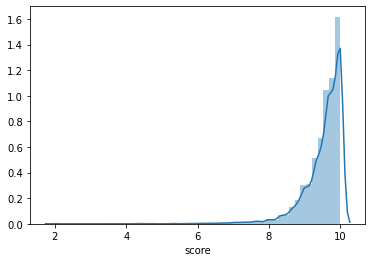

In [94]:
import seaborn as sns
sns.distplot(listings['score'].dropna())

In [0]:
def get_above_mean(x):
  mean = listings['score'].dropna().mean()
  if x>mean:
    return 1
  if x<=mean:
    return 0
  else:
    return np.NaN

In [0]:
def get_above_median(x):
  mean = listings['score'].dropna().median()
  if x>mean:
    return 1
  if x<=mean:
    return 0
  else:
    return np.NaN

In [0]:
listings_score = listings[host_score_columns[1:]+['score']]

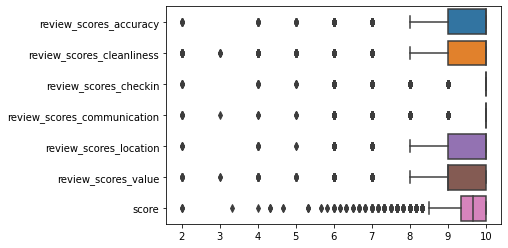

In [97]:
sns.boxplot(data = listings_score,orient='h')

In [0]:
listings['above_mean'] = listings['score'].apply(get_above_mean)

In [0]:
listings['above_median'] = listings['score'].apply(get_above_median)

In [45]:
listings['above_median'].value_counts()

0.0    4188
1.0    3302
Name: above_median, dtype: int64

In [100]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,score,above_mean
0,44077,https://www.airbnb.com/rooms/44077,20200321154917,2020-03-21,cosy comfortable Irish cottage twin,Our house was built in 1937 when there was ple...,"Hi, My name is Teresa and we have 3 rooms ava...",Our house was built in 1937 when there was ple...,none,I like our neighbourhood as there is no shorta...,Dundrum was always known as a Spa Town and the...,There is a bus stop 2 mins up the road from us...,We have a beautiful landscaped garden with tab...,We live on the premises so we are always on ha...,Welcome to our cottage and we hope you will en...,NaN,NaN,https://a0.muscache.com/im/pictures/525706/050...,NaN,193005,https://www.airbnb.com/users/show/193005,Teresa,2010-08-06,Dublin Ireland,"I am a friendly outgoing Irishwoman ,who love...",within an hour,100%,100%,t,https://a0.muscache.com/im/users/193005/profil...,https://a0.muscache.com/im/users/193005/profil...,Churchtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Churchtown, Ireland",Churchtown,Dn Laoghaire-Rathdown,...,1125,3,3,1125,1125,3.0,1125.0,a week ago,t,7,11,23,275,2020-03-21,227,38,2011-03-20,2020-03-06,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,t,t,3,0,3,0,2.07,10.0,1.0
1,85148,https://www.airbnb.com/rooms/85148,20200321154917,2020-03-21,Habitación en Dublín Double room,NaN,I'm renting a double room in my house in the s...,I'm renting a double room in my house in the s...,none,NaN,NaN,NaN,NaN,NaN,"Sorry, No smoking or pets. Lo siento esta proh...",NaN,NaN,https://a0.muscache.com/im/pictures/583752/61c...,NaN,466111,https://www.airbnb.com/users/show/466111,Don,2011-03-27,"Dublin, Ireland",I am single and live alone here so when I'm ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/466111/profil...,https://a0.muscache.com/im/users/466111/profil...,Templeogue,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Templeogue, Dublin, Ireland",Templeogue,South Dublin,...,5,1,1,5,5,1.0,5.0,4 months ago,t,0,0,0,140,2020-03-21,1,1,2019-05-11,2019-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0,1,0,0.09,NaN,NaN


In [0]:
#@title DTM lists
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

vect_dict = {'count':count_vect,'tfidf_word':tfidf_vect,'tfidf_ngram':tfidf_vect_ngram,'tfidf_ngram_chars':tfidf_vect_ngram_chars}

In [0]:
#@title get Train Test
from sklearn.model_selection import train_test_split
def get_train_test(vectorizer,sentences,y):
  sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,y)
  vectorizer.fit(sentences)
  X_train = vectorizer.transform(sentences_train)
  X_test  = vectorizer.transform(sentences_test)
  return X_train.toarray(),X_test.toarray(),y_train,y_test

# Single Complete Process

In [0]:
df_clean = pd.read_csv("/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/text_combined_lemm_rcommon.csv",index_col=0)

### remove the wrong rows

In [9]:
df_clean.shape

NameError: ignored

In [48]:
df_clean.head(1)

,id,text,rstop,lemmatization,rcommon
0.0,44077,our house was built in 1937 when there was ple...,house built 1937 plenty land originally dundru...,house built 1937 plenty land originally dundru...,built 1937 plenty land originally dundrum cons...


In [49]:
listings_score = listings[['id','score','above_median']]
outlier = []
for i in list(df_clean['id'].unique()):
  if len(i)>10:
    print(i)
    outlier.append(i)
listings_score.head(3)

cosy apartment available december 2nd december 12th inclusive fantastic location rathmines ranelagh making ideal anyone working city simply visiting dublin bus stop right outside apartment renelagh luas stop 5mins walk regular buses city centre airport train etc city centre grafton street 20mins walk parking incl fantastic cafes restaurants bars within walking distanceour cosy apartment available december 2nd december 12th inclusive fantastic location rathmines ranelagh making ideal anyone working city simply visiting dublin bus stop right outside apartment renelagh luas stop 5mins walk regular buses city centre airport train etc city centre grafton street 20mins walk parking incl fantastic cafes restaurants bars within walking distance local area fantastic abundance really great cafes bars restaurants within walking distance bus tram 5min walk regular service city centre shopping centres train airport etcentire apartment bedroom bathroom kitchen sitting roomi meet checkin travel food 

,id,score,above_median
0,44077,10.000000,1.0
1,85148,NaN,NaN
2,85156,9.833333,1.0


In [0]:
df_clean.reset_index(inplace=True)
o_list = df_clean[df_clean['id'].isin(outlier)].index.tolist()
df_clean = df_clean.drop(o_list)

In [0]:
df_clean['id'] = df_clean['id'].astype('int32')

In [0]:
df_clean = df_clean.merge(listings_score,left_on='id',right_on='id')[['id','text','rcommon','score','above_median']]

In [54]:
df_clean.head()

,id,text,rcommon,score,above_median
0,44077,our house was built in 1937 when there was ple...,built 1937 plenty land originally dundrum cons...,10.000000,1.0
1,85148,im renting a double room in my house in the ...,renting kingsize wooden showerbath approx 150 ...,NaN,NaN
2,85156,our cottage is a charming light filled cottage...,cottage charming light filled cottage vibrant ...,9.833333,1.0
3,121030,welcoming victorian house breakfast included d...,welcoming victorian included desk wooden beach...,9.166667,0.0
4,159889,washing can be done at a cost of five euro per...,washing done cost five euro per load light ser...,9.833333,1.0


In [0]:
save_path = '/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/'
df_clean.to_csv(save_path+'df_clean_with_score.csv')

# drop missing target

In [10]:
nan_list = df_clean[df_clean['score'].isnull()].index.tolist()
df_dn = df_clean.drop(nan_list)

NameError: ignored

In [0]:
target = 'rcommon'

In [0]:
sentences = df_dn[target].fillna('').values
y = df_dn['above_median']
y = label_binarize(y,classes=[0,1])
vectorizer = count_vect
X_train,X_test,y_train,y_test = get_train_test(vectorizer=vectorizer,sentences=sentences,y=y)

In [167]:
model = rf
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Evaluate

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine

In [148]:
y_score = model.fit(X_train,y_train).decision_function(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


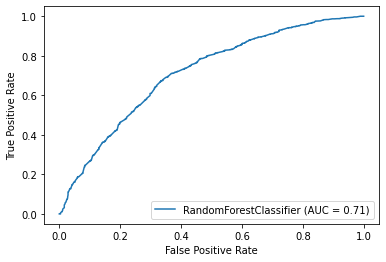

In [168]:
lr_disp = plot_roc_curve(model,X_test,y_test)

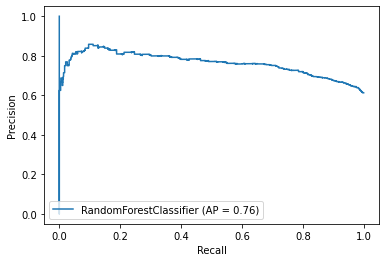

In [169]:
lr_disp = metrics.plot_precision_recall_curve(model,X_test,y_test)

In [180]:
from sklearn import metrics
predictions = model.predict(X_test)
print(metrics.accuracy_score(y_test,predictions))
print(metrics.roc_auc_score(y_test,predictions))
print(metrics.recall_score(y_test,predictions))
print(metrics.precision_score(y_test,predictions))
print(metrics.classification_report(y_test,predictions))
print(metrics.f1_score(y_test,predictions))
precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,predictions)
precision[0]

0.6801922050186866
0.6279506996868718
0.8660245183887916
0.689198606271777
              precision    recall  f1-score   support

           0       0.65      0.39      0.49       731
           1       0.69      0.87      0.77      1142

    accuracy                           0.68      1873
   macro avg       0.67      0.63      0.63      1873
weighted avg       0.67      0.68      0.66      1873

0.76755917733799


0.6506849315068494

# Classification Models

In [0]:
#@title Classification Models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [0]:
mlp = MLPClassifier() 
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
adb = AdaBoostClassifier()
gnb =  GaussianNB()
mnb = MultinomialNB()
lr = LogisticRegression()
svc = SVC()
cnb = ComplementNB()
rf = RandomForestClassifier()

In [0]:
model_dict = {
              # 'LogisticRegression':lr,
              # 'KNeighboirs': knn,
              # 'MultinomialNB': mnb,
              # 'MLP': mlp,
              # 'RandomForestClassifier': rf,
              # 'SVM':svc,
              'ComplementNB': cnb
             }

# Evaluate Methods

In [0]:
from sklearn.model_selection import cross_val_score,KFold
def evaluate_metrics(vectorizer_key,model_key,y_test,predictions):
  precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,predictions)
  metrics_dict = {
      'vectorizer_key':vectorizer_key,
      'model_key':model_key,
      'accuracy':metrics.accuracy_score(y_test,predictions),
      'roc_auc':metrics.roc_auc_score(y_test,predictions),
      'precision_0':precision[0],
      'recall_0':recall[0],
      'f1_0':f1[0],
      'precision_1':precision[1],
      'recall_1':recall[1],
      'f1_1':f1[1],
  }
  print(metrics_dict)
  return metrics_dict

In [184]:
evaluate_metrics(model,y_test)

{'accuracy': 0.6801922050186866,
 'f1_0': 0.4875962360992301,
 'f1_1': 0.76755917733799,
 'precision_0': 0.6506849315068494,
 'precision_1': 0.689198606271777,
 'recall_0': 0.3898768809849521,
 'recall_1': 0.8660245183887916,
 'roc_auc': 0.6279506996868718}

# Prepare the train test

In [0]:
import os
path = '/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/'
save_path = '/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/Classification_Results/'
file_list = os.listdir(path)
file_list = file_list[1:-4]
file_list = ['PP_summary.csv',
#  'PP_space.csv',
#  'PP_neighborhood_overview.csv',
# #  'PP_description.csv',
#  'PP_access.csv',
#  'PP_interaction.csv',
# #  'PP_notes.csv',
#  'PP_host_about.csv',
# #  'PP_house_rules.csv',
#  'PP_transit.csv',
 ]
text_list=['text','lemmatization']
text_list=['text']
# vect_dict = {'count':count_vect,'tfidf_word':tfidf_vect,'tfidf_ngram':tfidf_vect_ngram,'tfidf_ngram_chars':tfidf_vect_ngram_chars}
vect_dict = {'tfidf_ngram_chars':tfidf_vect_ngram_chars}

In [0]:
label = 'above_mean'
for f in file_list:
    text_name = f[3:-4]
    print(text_name)
    df = pd.read_csv(path+f,index_col=0)
    df[label] = listings[label]
    nan_list = df[df[label].isnull()].index.tolist()
    df = df.drop(nan_list)
    for target in text_list:
      sentences = df[target].fillna('').values
      y = df[label]
      for vect_key in vect_dict:
        print('===>'+vect_key)
        vect = vect_dict[vect_key]
        X_train,X_test,y_train,y_test = get_train_test(vect,sentences,y)
        print('start working on '+text_name+' '+target)
        result_list = []
        prediction_list = []
        for model_key in model_dict:
          print('------> '+model_key)
          model = model_dict[model_key]
          model.fit(X_train.toarray(),y_train)
          predictions = model.predict(X_test.toarray())
          prediction_list.append({model_key:predictions})
          # accuracy_mean,accuracy_std = evaluate_accuracy(model,X_train.toarray(),y_train)
          # result_dict = {
          #     'text_name' : text_name,
          #     'target' : target,
          #     'feature_type' : vect_key,
          #     'model': model_key,
          #     'accuracy_mean' : accuracy_mean,
          #     'accuracy_std' : accuracy_std,
          # }
          # result_list.append(result_list)
        pd.DataFrame(result_list).to_csv(save_path+'{}_{}_results.csv'.format(text_name,target))

summary
===>tfidf_ngram_chars


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


start working on summary text
------> SVM


In [0]:
predictions = prediction_list[0]['SVM']

In [0]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test.toarray())
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.59      0.29      0.39       729
         1.0       0.66      0.87      0.75      1144

    accuracy                           0.65      1873
   macro avg       0.63      0.58      0.57      1873
weighted avg       0.63      0.65      0.61      1873



In [0]:
pred = pd.Series(predictions)

In [0]:
pd.concat([pred,y_test.reset_index()],axis=1)

,0,index,above_mean
0,1.0,6094,1.0
1,1.0,8821,0.0
2,1.0,810,1.0
3,1.0,748,1.0
4,1.0,6500,1.0
...,...,...,...
1868,1.0,7719,0.0
1869,0.0,6936,1.0
1870,1.0,7903,1.0
1871,1.0,1433,1.0


In [0]:
predictions = model.predict(X_test.toarray())

# Apply on clean dataset

In [16]:
df = pd.read_csv('/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/df_clean_with_score.csv',index_col=0)
nan_list = df[df['score'].isnull()].index.tolist()
print(len(nan_list))
df_dn = df.drop(nan_list)

1653


In [17]:
df_dn.head()

,id,text,rcommon,score,above_median
0,44077,our house was built in 1937 when there was ple...,built 1937 plenty land originally dundrum cons...,10.000000,1.0
2,85156,our cottage is a charming light filled cottage...,cottage charming light filled cottage vibrant ...,9.833333,1.0
3,121030,welcoming victorian house breakfast included d...,welcoming victorian included desk wooden beach...,9.166667,0.0
4,159889,washing can be done at a cost of five euro per...,washing done cost five euro per load light ser...,9.833333,1.0
5,162809,a nice place to relax after the bustle of the ...,relax bustle sea far mountain really hill top ...,10.000000,1.0


In [0]:
target = 'rcommon'
sentences = df_dn[target].fillna('').values
y = df_dn['above_median']
# y = label_binarize(y,classes=[0,1])

## Steps
1. iterate vectorizers
2. iterate models
3. evaluate the predictions
4. store in the DataFrame

In [74]:
print (model_dict)

{'ComplementNB': ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)}


In [75]:
# result_list = []
for vectorizer_key in vect_dict:
  print("current working on: "+ vectorizer_key)
  vectorizer = vect_dict[vectorizer_key]
  X_train,X_test,y_train,y_test = get_train_test(vectorizer=vectorizer,sentences=sentences,y=y)
  for model_key in model_dict:
    model = model_dict[model_key]
    print('current_working on:'+ model_key)
    train_model(model,X_train,y_train)
    predictions = model.predict(X_test)
    res_dict = evaluate_metrics(vectorizer_key,model_key,y_test,predictions)
    result_list.append(res_dict)
  # break

current working on: count
current_working on:ComplementNB
{'vectorizer_key': 'count', 'model_key': 'ComplementNB', 'accuracy': 0.6374799786438868, 'roc_auc': 0.6367245700758895, 'precision_0': 0.6941896024464832, 'recall_0': 0.6424528301886793, 'f1_0': 0.6673199412052916, 'precision_1': 0.5751121076233184, 'recall_1': 0.6309963099630996, 'f1_1': 0.6017595307917889}
current working on: tfidf_word
current_working on:ComplementNB
{'vectorizer_key': 'tfidf_word', 'model_key': 'ComplementNB', 'accuracy': 0.6182594767752269, 'roc_auc': 0.6147130318285718, 'precision_0': 0.652046783625731, 'recall_0': 0.6514118792599806, 'f1_0': 0.6517291768144179, 'precision_1': 0.577331759149941, 'recall_1': 0.5780141843971631, 'f1_1': 0.5776727702303603}
current working on: tfidf_ngram
current_working on:ComplementNB
{'vectorizer_key': 'tfidf_ngram', 'model_key': 'ComplementNB', 'accuracy': 0.5856914041644421, 'roc_auc': 0.6034513776449261, 'precision_0': 0.7018633540372671, 'recall_0': 0.4362934362934363,

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


current_working on:ComplementNB
{'vectorizer_key': 'tfidf_ngram_chars', 'model_key': 'ComplementNB', 'accuracy': 0.6187933796049119, 'roc_auc': 0.6088778893137267, 'precision_0': 0.6464826357969724, 'recall_0': 0.6960690316395014, 'f1_0': 0.670360110803324, 'precision_1': 0.5773333333333334, 'recall_1': 0.5216867469879518, 'f1_1': 0.5481012658227848}


In [0]:
df_result = pd.DataFrame(result_list)
df_result.to_csv('/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/Classification_Results/text_results.csv')

In [0]:
df_result.sort_values('roc_auc').tail().to_csv("/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/Classification_Results/text_results_tail.csv")

In [0]:
df_result = pd.read_csv('/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/Classification_Results/text_results.csv',index_col=0)

In [17]:
df_result.sort_values('roc_auc').tail()

,vectorizer_key,model_key,accuracy,roc_auc,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
4,tfidf_word,MultinomialNB,0.646556,0.629195,0.658537,0.769962,0.709904,0.623639,0.488429,0.547814
5,tfidf_word,SVM,0.643353,0.631024,0.666378,0.730989,0.697189,0.606398,0.531060,0.566234
3,tfidf_word,LogisticRegression,0.646556,0.632806,0.665816,0.744297,0.702873,0.614060,0.521315,0.563900
12,count,ComplementNB,0.637480,0.636725,0.694190,0.642453,0.667320,0.575112,0.630996,0.601760
1,count,MultinomialNB,0.638548,0.639792,0.696523,0.629524,0.661331,0.579004,0.650061,0.612479


In [86]:
df_result.groupby('vectorizer_key').max()

,model_key,accuracy,roc_auc,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
vectorizer_key,,,,,,,,,
count,SVM,0.643353,0.639792,0.696523,0.795238,0.714286,0.632479,0.650061,0.612479
tfidf_ngram,SVM,0.595836,0.603451,0.701863,0.741617,0.665192,0.581470,0.770609,0.624395
tfidf_ngram_chars,SVM,0.632141,0.616621,0.646483,0.845043,0.712952,0.641425,0.521687,0.548101
tfidf_word,SVM,0.646556,0.632806,0.666378,0.769962,0.709904,0.623639,0.578014,0.577673


In [85]:
df_result.groupby('model_key').max()

,vectorizer_key,accuracy,roc_auc,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
model_key,,,,,,,,,
ComplementNB,tfidf_word,0.637480,0.636725,0.701863,0.696069,0.670360,0.577333,0.770609,0.624395
LogisticRegression,tfidf_word,0.646556,0.632806,0.665816,0.757459,0.702873,0.614060,0.521315,0.563900
MultinomialNB,tfidf_word,0.646556,0.639792,0.696523,0.845043,0.712952,0.641425,0.650061,0.612479
SVM,tfidf_word,0.643353,0.631024,0.666378,0.795238,0.714286,0.632479,0.531060,0.566234


In [0]:
def train_model(model,X_train,y_train):
  model.fit(X_train,y_train)
  return model

In [18]:
for model_key in model_dict:
  model = model_dict[model_key]
  print('current_working on:'+ model_key)
  train_model(model,X_train,y_train)

current_working on:LogisticRegression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


current_working on:MultinomialNB
current_working on:SVM


In [0]:
result_list = []
for model_key in model_dict:
  print('current_working on:'+ model_key)
  model = model_dict[model_key]
  predictions = model.predict(X_test)
  res_dict = evaluate_metrics(y_test,predictions)
  result_list.append(res_dict)

# Optimize Model

In [18]:
df_result.sort_values('roc_auc').tail()

,vectorizer_key,model_key,accuracy,roc_auc,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
4,tfidf_word,MultinomialNB,0.646556,0.629195,0.658537,0.769962,0.709904,0.623639,0.488429,0.547814
5,tfidf_word,SVM,0.643353,0.631024,0.666378,0.730989,0.697189,0.606398,0.531060,0.566234
3,tfidf_word,LogisticRegression,0.646556,0.632806,0.665816,0.744297,0.702873,0.614060,0.521315,0.563900
12,count,ComplementNB,0.637480,0.636725,0.694190,0.642453,0.667320,0.575112,0.630996,0.601760
1,count,MultinomialNB,0.638548,0.639792,0.696523,0.629524,0.661331,0.579004,0.650061,0.612479


### 1. count	MultinomialNB

In [0]:
vectorizer = count_vect
model = MultinomialNB()

In [0]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
gsearch = GridSearchCV(estimator=MultinomialNB(),param_grid=parameters,scoring='roc_auc',cv=5)

In [0]:
gsearch = GridSearchCV(estimator=MultinomialNB(),param_grid=parameters,scoring='accuracy',cv=5)

In [0]:
vectorizer.fit(sentences)
X = vectorizer.transform(sentences).toarray()
# gsearch.fit(X,y)

In [39]:
Opt_mnb_param = gsearch.best_params_
Opt_mnb_param

{'alpha': 1}

In [0]:
Opt_mnb = MultinomialNB(alpha=1.0)

In [0]:
Opt_mnb = gsearch.best_estimator_

In [41]:
best_roc_auc_mnb = gsearch.best_score_
best_roc_auc_mnb

0.6221628838451267

In [44]:
vectorizer = count_vect
X_train,X_test,y_train,y_test = get_train_test(vectorizer,sentences,y)
Opt_mnb.fit(X_train,y_train)
predictions = Opt_mnb.predict(X_test)
mnb_dict = evaluate_metrics('count','MultinomialNB',y_test,predictions)

{'vectorizer_key': 'count', 'model_key': 'MultinomialNB', 'accuracy': 0.6316070475173519, 'roc_auc': 0.6326639999263077, 'precision_0': 0.6801275239107333, 'recall_0': 0.6219630709426628, 'f1_0': 0.649746192893401, 'precision_1': 0.5826180257510729, 'recall_1': 0.6433649289099526, 'f1_1': 0.6114864864864864}


### 2. tfidf word	MultinomialNB

In [0]:
vectorizer = tfidf_vect

In [0]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
gsearch = GridSearchCV(estimator=MultinomialNB(),param_grid=parameters,scoring='roc_auc',cv=5)

In [44]:
vectorizer.fit(sentences)
X = vectorizer.transform(sentences).toarray()
gsearch.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [45]:
Opt_mnb_tfidf_param = gsearch.best_params_
Opt_mnb_tfidf_param

{'alpha': 1}

In [43]:
vectorizer = tfidf_vect
Opt_tfidf_mnb = MultinomialNB()
X_train,X_test,y_train,y_test = get_train_test(vectorizer,sentences,y)
Opt_tfidf_mnb.fit(X_train,y_train)
predictions = Opt_tfidf_mnb.predict(X_test)
mnb_tfidf_dict = evaluate_metrics('tfidf_word','MultinomialNB',y_test,predictions)

{'vectorizer_key': 'tfidf_word', 'model_key': 'MultinomialNB', 'accuracy': 0.6353443673251469, 'roc_auc': 0.6158419311199126, 'precision_0': 0.6587561374795418, 'recall_0': 0.7516339869281046, 'f1_0': 0.7021369385085041, 'precision_1': 0.5913978494623656, 'recall_1': 0.4800498753117207, 'f1_1': 0.5299380591878872}


### 3. count	ComplementNB

In [0]:
vectorizer = count_vect

In [0]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
'norm':(False,True),
'fit_prior':(False,True)  
}  
gsearch = GridSearchCV(estimator=ComplementNB(),param_grid=parameters,scoring='roc_auc',cv=5)

In [49]:
vectorizer.fit(sentences)
X = vectorizer.transform(sentences).toarray()
# gsearch.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                                    norm=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05),
                         'fit_prior': (False, True), 'norm': (False, True)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [0]:
Opt_cnb = gsearch.best_estimator_

In [51]:
gsearch.best_params_

{'alpha': 1, 'fit_prior': False, 'norm': False}

In [0]:
Opt_cnb = ComplementNB(alpha=1,fit_prior=False,norm=False)

In [52]:
gsearch.best_score_

0.6751756731180907

In [42]:
vectorizer = count_vect
Opt_cnb = ComplementNB(alpha=1,fit_prior=False,norm=False)
X_train,X_test,y_train,y_test = get_train_test(vectorizer,sentences,y)
Opt_cnb.fit(X_train,y_train)
predictions = Opt_cnb.predict(X_test)
cnb_dict = evaluate_metrics('count','ComplementNB',y_test,predictions)

{'vectorizer_key': 'count', 'model_key': 'ComplementNB', 'accuracy': 0.6358782701548318, 'roc_auc': 0.6384563412539365, 'precision_0': 0.6795454545454546, 'recall_0': 0.5991983967935872, 'f1_0': 0.6368477103301384, 'precision_1': 0.5971802618328298, 'recall_1': 0.6777142857142857, 'f1_1': 0.6349036402569594}


### 4. tfidf_word	LogisticRegression

In [0]:
vectorizer = tfidf_vect

In [0]:
parameters={"C":[0.01,0.1,1], 
            "penalty":["l1","l2",'none','elasticnet'],
            # 'solver': ['liblinear', 'sag', 'saga','lbfgs'],
            'solver': ['saga']
            }
gsearch = GridSearchCV(estimator=LogisticRegression(),param_grid=parameters,scoring='roc_auc',cv=5)

In [0]:
vectorizer.fit(sentences)
X = vectorizer.transform(sentences).toarray()
gsearch.fit(X,y)

In [70]:
gsearch.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [73]:
gsearch.best_score_

0.6714925207118214

In [0]:
Opt_lr = gsearch.best_estimator_

In [78]:
vectorizer = tfidf_vect
Opt_lr = gsearch.best_estimator_
X_train,X_test,y_train,y_test = get_train_test(vectorizer,sentences,y)
Opt_lr.fit(X_train,y_train)
predictions = Opt_lr.predict(X_test)
lr_dict = evaluate_metrics('tfidf_word','LogisticRegression',y_test,predictions)

{'vectorizer_key': 'tfidf_word', 'model_key': 'LogisticRegression', 'accuracy': 0.600106780565937, 'roc_auc': 0.5580042712893463, 'precision_0': 0.5933997509339975, 'recall_0': 0.9084842707340324, 'f1_0': 0.7178907721280602, 'precision_1': 0.6404494382022472, 'recall_1': 0.20752427184466019, 'f1_1': 0.31347387717690195}


### 5. tfidf_word	SVM

In [0]:
vectorizer = tfidf_vect
vectorizer.fit(sentences)
X = vectorizer.transform(sentences).toarray()
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [0]:
gsearch = GridSearchCV(estimator=SVC(),param_grid=parameters,scoring='accuracy',cv=3)

In [92]:
gsearch.fit(X,y)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [93]:
gsearch.best_params_

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [95]:
gsearch.best_score_

0.6205608589281497

In [96]:
Opt_svm = gsearch.best_estimator_
vectorizer = tfidf_vect
X_train,X_test,y_train,y_test = get_train_test(vectorizer,sentences,y)
Opt_svm.fit(X_train,y_train)
predictions = Opt_svm.predict(X_test)
svm_dict = evaluate_metrics('tfidf_word','SVM',y_test,predictions)

{'vectorizer_key': 'tfidf_word', 'model_key': 'SVM', 'accuracy': 0.6166577682861719, 'roc_auc': 0.5888690750115049, 'precision_0': 0.6021290751829674, 'recall_0': 0.8829268292682927, 'f1_0': 0.7159810126582279, 'precision_1': 0.6756756756756757, 'recall_1': 0.294811320754717, 'f1_1': 0.4105090311986864}


Random Forest

In [117]:
vectorizer = count_vect
X_train,X_test,y_train,y_test = get_train_test(vectorizer,sentences,y)
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
svm_dict = evaluate_metrics('count','Random Forest',y_test,predictions)

{'vectorizer_key': 'count', 'model_key': 'Random Forest', 'accuracy': 0.5274959957287774, 'roc_auc': 0.4893805330237968, 'precision_0': 0.5562208915502329, 'recall_0': 0.793168880455408, 'f1_0': 0.6538912788423935, 'precision_1': 0.41081081081081083, 'recall_1': 0.1855921855921856, 'f1_1': 0.255677039529016}


## evaluate opt models

In [105]:
# result_list_opt = [svm_dict]
# df_res_opt_ = pd.DataFrame(result_list_opt)
# df_res_opt = pd.concat([df_res_opt_,df_res_opt])
# df_res_opt.reset_index()
df_res_opt = df_res_opt.iloc[2:]
df_res_opt

,vectorizer_key,model_key,accuracy,roc_auc,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
0,tfidf_word,SVM,0.616658,0.588869,0.602129,0.882927,0.715981,0.675676,0.294811,0.410509
0,tfidf_word,LogisticRegression,0.600107,0.558004,0.593400,0.908484,0.717891,0.640449,0.207524,0.313474
0,count,MultinomialNB,0.631607,0.632664,0.680128,0.621963,0.649746,0.582618,0.643365,0.611486
1,tfidf_word,MultinomialNB,0.635344,0.615842,0.658756,0.751634,0.702137,0.591398,0.480050,0.529938
2,count,ComplementNB,0.635878,0.638456,0.679545,0.599198,0.636848,0.597180,0.677714,0.634904


In [0]:
df_res_opt.to_csv('/content/drive/My Drive/CA683 Data Mining/Continuous Assignment/DataMining_Assignment/Data/Classification_Results/df_res_opt.csv')

In [0]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

In [0]:
X_train,X_test_count,y_train,y_test_count = get_train_test(count_vect,sentences,y)
X_train,X_test_tfidf,y_train,y_test_tfidf = get_train_test(tfidf_vect,sentences,y)
# Opt_tfidf_mnb
# Opt_mnb
# Opt_cnb

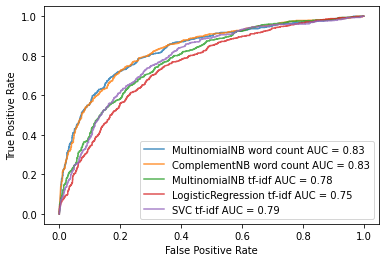

In [108]:
ax = plt.gca()
mnb_disp = plot_roc_curve(Opt_mnb,X_test_count,y_test_count,ax=ax,alpha=0.8,label='MultinomialNB word count AUC = 0.83')
cnb_disp = plot_roc_curve(Opt_cnb,X_test_count,y_test_count,ax=ax,alpha=0.8,label='ComplementNB word count AUC = 0.83')
mnb_tfidf_dict = plot_roc_curve(Opt_tfidf_mnb,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8,label='MultinomialNB tf-idf AUC = 0.78')
lr_tfidf_dict = plot_roc_curve(Opt_lr,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8,label='LogisticRegression tf-idf AUC = 0.75')
svm_tfidf_dict = plot_roc_curve(Opt_svm,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8,label='SVC tf-idf AUC = 0.79')

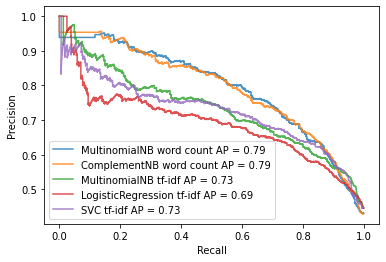

In [113]:
ax = plt.gca()
mnb_disp = metrics.plot_precision_recall_curve(Opt_mnb,X_test_count,y_test_count,ax=ax,alpha=0.8,label='MultinomialNB word count AP = 0.79')
cnb_disp = metrics.plot_precision_recall_curve(Opt_cnb,X_test_count,y_test_count,ax=ax,alpha=0.8,label='ComplementNB word count AP = 0.79')
mnb_tfidf_dict = metrics.plot_precision_recall_curve(Opt_tfidf_mnb,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8,label='MultinomialNB tf-idf AP = 0.73')
lr_tfidf_dict = metrics.plot_precision_recall_curve(Opt_lr,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8,label='LogisticRegression tf-idf AP = 0.69')
svm_tfidf_dict = metrics.plot_precision_recall_curve(Opt_svm,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8,label='SVC tf-idf AP = 0.73')

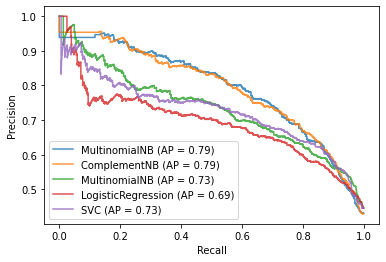

In [112]:
ax = plt.gca()
mnb_disp = metrics.plot_precision_recall_curve(Opt_mnb,X_test_count,y_test_count,ax=ax,alpha=0.8)
cnb_disp = metrics.plot_precision_recall_curve(Opt_cnb,X_test_count,y_test_count,ax=ax,alpha=0.8)
mnb_tfidf_dict = metrics.plot_precision_recall_curve(Opt_tfidf_mnb,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8)
lr_tfidf_dict = metrics.plot_precision_recall_curve(Opt_lr,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8)
svm_tfidf_dict = metrics.plot_precision_recall_curve(Opt_svm,X_test_tfidf,y_test_tfidf,ax=ax,alpha=0.8)